# EffectiveHalos Usage

### Initializing the Module

To use EffectiveHalos, first load the Cosmology module to set the cosmological parameters and redshift. The class accepts either the name of a pre-loaded cosmology, or any parameters used by CLASS. For a list of available cosmologies see the docstrings, or the full API.

Here we'll initialize with the cosmology used in the Quijote simulations at redshift zero: 

In [1]:
from EffectiveHalos import *
import numpy as np
import matplotlib.pyplot as plt

z = 0.
cosmology = Cosmology(z, name = 'Quijote', verb = True) # set verb = True to display useful messages throughout runtime

Loading the Quijote cosmology at z = 0.00
Loading CLASS


Next, load the mass function. Here we'll use the prescription of Bhattacharya et al. 2010:

In [2]:
mass_function = MassFunction(cosmology, mass_function_name = 'Bhattacharya', verb = True)

Using fitted parameters for the Bhattacharya mass function from Quijote simulations 


Finally, the HaloPhysics class must be initialized. This includes the halo profile and concentration. We'll use the standard NFW profiles (Navarro et al. 1999) and the halo concentration prescription of Duffy et al. 2010:

In [3]:
halo_physics = HaloPhysics(cosmology, mass_function, concentration_name = 'Duffy', profile_name = 'NFW', verb = True)

Creating an interpolator for sigma(M) and its derivative.


This class contains a number of optional arguments controlling interpolation and the mass function limits. For more information, see the module API.

### Computing Power Spectra

In this section, we'll compute model power spectra with free parameters fitted to the mean of 100 high-resolution Quijote $N$-body simulations. This is provided with the module, using $k_\mathrm{max} = 0.8h\,\mathrm{Mpc}^{-1}$.

The first step is to load the simulation data, and initialize the HaloModel class:

In [9]:
# Load simulated data
k, Pk, Pk_err = np.loadtxt('/home/ophilcox/EffectiveHalos/quijote_HR_spectra_z0.txt', unpack = True)

# Initialize the HaloPower class
halo_model = HaloModel(cosmology, mass_function, halo_physics, k, verb = True)

Power spectra can be computed using the ``halo_model()`` function. This features a number of optional arguments which control various features of the power spectrum model. The full effective halo model is obtained by setting these to their default values. 

The Effective Halo Model requires two free parameters; the effective sound speed $c_s^2$ and the density field smoothing scale $R$. Here we'll set them by comparing the model spectrum to the Quijote simulations.

Note that power spectra computation takes a few seconds the first time it is run since numerical integrals must be computed, but negligible time for any additional runs.

In [10]:
# Create a simple Gaussian likelihood
def likelihood(parameters):
    cs2, R = parameters
    model_Pk = halo_model.halo_model(cs2, R)
    return np.sum((model_Pk - Pk)**2. / Pk_err**2.)
    
# Optimize free parameters
from scipy.optimize import minimize
p0 = [1., 1.]
output = minimize(likelihood, p0)
cs2, R = output.x

print("Optimal parameters are c_s^2 = %.2f, R = %.2f"%(cs2, R))

Computing one-loop power spectrum
Non-linear BAO damping scale = 5.47 Mpc/h
Computing one-loop power spectrum
Optimal parameters are c_s^2 = 9.36, R = 1.76


Let's plot the fitted power spectrum from the effective halo model, alongside the prediction from the standard halo model. Note that we canalso return the one- and two-halo terms separately using the ``return_terms`` argument of the ``halo_model()`` function.

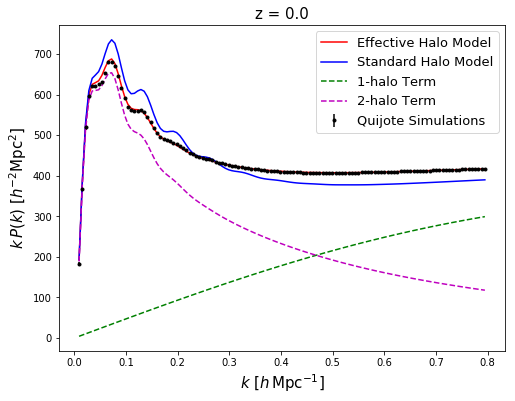

In [11]:
# Compute the spectrum using the effective halo model
power_EHM, power_1h, power_2h = halo_model.halo_model(cs2, R, return_terms = True)

# Compute the spectrum using the standard halo model
power_SHM = halo_model.halo_model(cs2, R, pt_type = 'Linear', pade_resum = False, smooth_density = False,
                                 IR_resum = False, return_terms = False)

# Plot the results
plt.figure(figsize = (8,6))
plt.plot(k, k * power_EHM, c = 'r', label = 'Effective Halo Model')
plt.plot(k, k * power_SHM, c = 'b', label = 'Standard Halo Model')
plt.errorbar(k, k * Pk, yerr = k * Pk_err, ls = '', marker = '.', c = 'k', label = 'Quijote Simulations')
plt.plot(k, k * power_1h, ls = '--', c = 'g', label = '1-halo Term')
plt.plot(k, k * power_2h, ls = '--', c = 'm', label = '2-halo Term')
plt.xlabel(r'$k$ [$h\,\mathrm{Mpc}^{-1}$]', fontsize = 15)
plt.ylabel(r'$k\,P(k)$ [$h^{-2}\mathrm{Mpc}^{2}$]', fontsize = 15)
plt.title(r'z = %s'%z, fontsize = 15)
plt.legend(fontsize = 13)
plt.show()

To see this in more detail, let's plot the ratio:

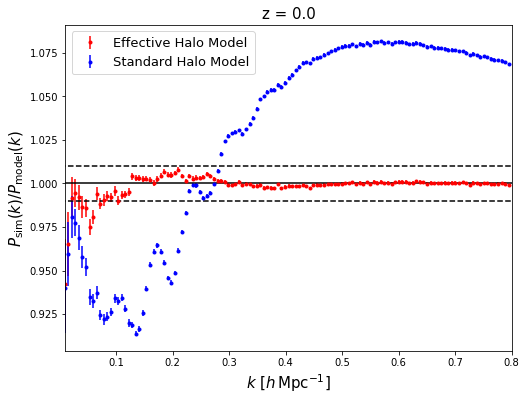

In [12]:
plt.figure(figsize = (8,6))
plt.errorbar(k, Pk / power_EHM, yerr = Pk_err / power_EHM, ls = '', marker = '.', c = 'r', label = 'Effective Halo Model')
plt.errorbar(k, Pk / power_SHM, yerr = Pk_err / power_SHM, ls = '', marker = '.', c = 'b', label = 'Standard Halo Model')
plt.xlabel(r'$k$ [$h\,\mathrm{Mpc}^{-1}$]', fontsize = 15)
plt.ylabel(r'$P_\mathrm{sim}(k) / P_\mathrm{model}(k)$', fontsize = 15)
plt.title(r'z = %s'%z, fontsize = 15)
plt.legend(fontsize = 13)
plt.hlines(1., 0, 1)
plt.hlines([0.99, 1.01], 0, 1, linestyles = '--')
plt.xlim([0.01, 0.8])
plt.show()

### Computing Covariance Matrices

EffectiveHalos can be used to compute the covariance matrices of halo counts. This is done using the ``CountsCovariance`` class. Below, we compute and plot the covariance matrix for a selection of massive halos using the ``NN_covariance()`` function. This uses the optimal parameters $c_s^2$ and $R$ found above. We will additionally set the exclusion parameter $\alpha$ to $1/2$.

Note that there are three contributions to the covariance; intrinsic, extrinsic and super-sample covariances. These can be turned off using the ``use_SSC`` and ``use_exclusion`` arguments. An important hyperparameter is $\sigma^2(V)$; the variance of the linear density field across the survey or simulation. This can be computed separately and passed to EffectiveHalos. If this is not present, it will be computed using CLASS, assuming that the survey is isotropic (rarely a valid assumption).

In [ ]:
# Define parameters
mass_bins = np.logspace(13, 15, 10) # mass bin limits in Msun/h units
volume = 1000.**3. # survey volume in (Mpc/h)^3
alpha = 0.5 # exclusion parameter, in range (0, 1)

# Load the class
counts_covariance = CountsCovariance(cosmology, mass_function, halo_physics, k, mass_bins, volume, verb = True)

# Compute the covariance of halo counts
cov_NN = counts_covariance.NN_covariance(cs2, R, alpha, use_SSC = True, use_exclusion = True)

# Plot the covariance
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
cax = ax.matshow(cov_NN)
fig.colorbar(cax)
ax.xaxis.tick_bottom()
ax.set_title(r'Halo Count Covariance at z = %s'%z);

Computing intrinsic covariance terms
Computing mass integrals
Computing exclusion covariance terms
Computing interpolation grid for non-linear S function


Finally, we can compute the covariance between halo counts and the matter power spectrum using the ``NP_covariance()`` function. We'll do this for the mass bins specfied above, including all sources of covariance.

In [ ]:
# Compute the covariance of halo counts
cov_NP = counts_covariance.NP_covariance(cs2, R, alpha, use_SSC = True, use_exclusion = True)

# Define means of mass bins
mass_mean = 0.5*(mass_bins[1:] + mass_bins[:-1])

# Plot the output
plt.figure(figsize = (8,6))
for i in range(len(mass_mean)):
    plt.plot(k, k * cov_NP[i], label = "%.1f"%(np.log10(mass_mean[i])))
plt.ylabel(r'$k \times \mathrm{cov}\left[N(m), P(k)\right]$', fontsize = 15)
plt.xlabel(r'$k$ [$h\,\mathrm{Mpc}^{-1}$]', fontsize = 15)
plt.legend(fontsize = 13)
plt.xlim([0,1])
plt.title('Halo Count and Matter Power Spectrum Cross-Covariance at $z = %s$'%z, fontsize = 14);

This completes the tutorial!